In [1]:
## yikes idk how you would do this anymore
import sys 
sys.path.insert(0, '../')

%load_ext autoreload
%aimport processing, basket, coin
%matplotlib inline

In [2]:
%autoreload 1

import pandas as pd
import numpy as np

import datetime
from datetime import timezone
import pytz

from pycoingecko import CoinGeckoAPI

from processing import Processor
from basket import Basket
from coin import Coin
from CGProcessor import CGProcessor
sys.path.pop(0)
from bin import Statistics, Tests, Transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F



2021-11-05 07:22:52.524372
1636122172.524464 1636096972.52447


ImportError: cannot import name 'Tests' from 'bin' (unknown location)

In [16]:
# coin_list = cg.get_coins_list()

# ids = [coin_data['id'] for coin_data in coin_list]

# id_to_data = {}
# for coin_data in coin_list:
#     id_to_data[coin_data.pop('id')] = coin_data
# ids = id_to_data.keys()

In [17]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)

In [18]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']
start_date, end_date = (2020,1,1), (2021,10,31)

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [19]:
##################
## LOCAL DRIVER ##
##################

cgp = CGProcessor()

# Create portfolio dataframe
port_val = cgp.create_portfolio(PORT_IDS, start_date, end_date)
data = cgp.data

cgp.normalize([], port=True)

In [20]:
display(data)

,bitcoin,bitcoin-cash,ethereum,litecoin
1577836800000,7195.153895,204.561792,129.186385,41.330312
1577923200000,7193.754668,204.348311,130.484685,41.606316
1578009600000,6963.853354,195.674640,127.045258,39.413813
1578096000000,7300.346935,221.621452,133.702649,41.991047
1578182400000,7351.377053,224.487505,134.136883,42.781417
...,...,...,...,...
1635292800000,60604.188888,609.848740,4152.570289,198.406010
1635379200000,58641.001474,551.244177,3944.090862,180.241936
1635465600000,60767.555852,579.019616,4288.097219,190.168430
1635552000000,62283.198056,591.975602,4422.940536,196.704274


# Tests
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is order-1 integrable</li>
    <li>Create basket of coins, find linear regression.</li>
    <li>Verify spread of basket is cointegrated.</li>
    <li>Define strategy for basket trades.</li>
</ol>

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

Verifying coin price stationarity...
['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']  are stationary 

Fitting linear_regression ...
Found coefficients for basket:  [1, -66.41456935145987, 6.317443097671294, 340.5467553326034]
At intercept:  8199.409989048647
Basket is valid, all coins are I(1).


Cointegration test returned: True


<Figure size 432x288 with 0 Axes>

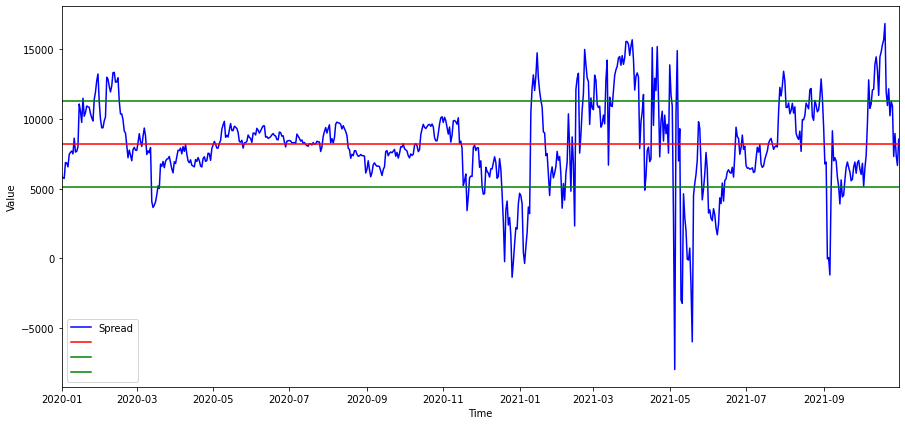

In [24]:
############
## TEST 1 ##
############

# print("Normalizing...")
# scaler = MinMaxScaler()
# scaler.fit(X, y)
# X_scaled = scaler.transform(X) # TODO: Finish normalization
# X_scaled = pd.DataFrame(X_scaled/X_scaled[0], index=X.index) 
# X_scaled.columns = X.columns

print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

print([coin.name_ for coin in coins], " are stationary \n")
        
basket = Basket(coins, target='bitcoin', processor=cgp)
basket.fit(data)
spread = basket.find_spread(data)
is_cointegrated = basket.is_coint(spread)
print("\n")
print("Cointegration test returned:", is_cointegrated)

short_entry, long_entry = basket.strat(spread)

<Figure size 432x288 with 0 Axes>

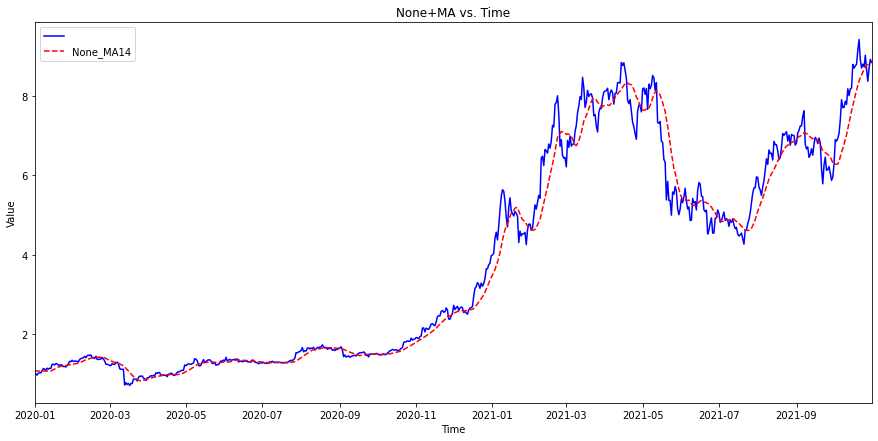

NameError: name 'coint_res' is not defined

In [25]:
############
## TEST 2 ##
############

# Create normalized timeseries for portfolio
port_rm = cgp.roll_avg(ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


# IF a random variable is stationary THEN it is also order one integratable #

port_ret = Transforms.integrate(port_rm)

comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
# TODO: This needs to be standardized as a basket, then 
# coint_res = Tests.is_coint(port_ret, comparator)
#print(coint_res)

### Testing cointegration of crypto basket
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is order-1 integrable</li>
    <li>Create basket of coins, find linear regression.</li>
    <li>Verify spread of basket is cointegrated.</li>
    <li>Define strategy for basket trades.</li>
</ol>

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

In [26]:
############
## TEST 3 ##
############

d_1, d_2 = CGProcessor.id_to_prices(cgp.cg, PORT_IDS[0], start_date, end_date), CGProcessor.id_to_prices(cgp.cg, PORT_IDS[1], start_date, end_date)
s_1, s_2 = pd.Series(d_1), pd.Series(d_2)
s_1.name, s_2.name = PORT_IDS[0], PORT_IDS[1]

# Random two series likely should not be stationary
coint_res = Tests.is_coint(s_1, s_2)
print(coint_res)

AttributeError: module 'bin.Tests' has no attribute 'is_coint'

<Figure size 432x288 with 0 Axes>

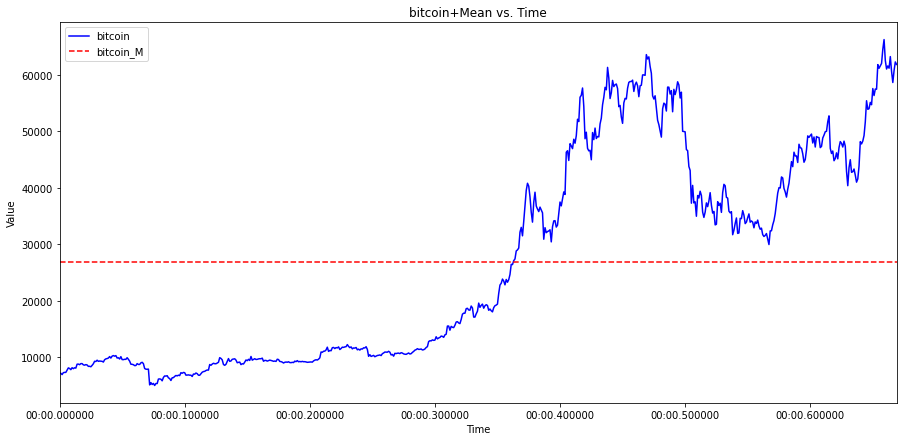

<Figure size 432x288 with 0 Axes>

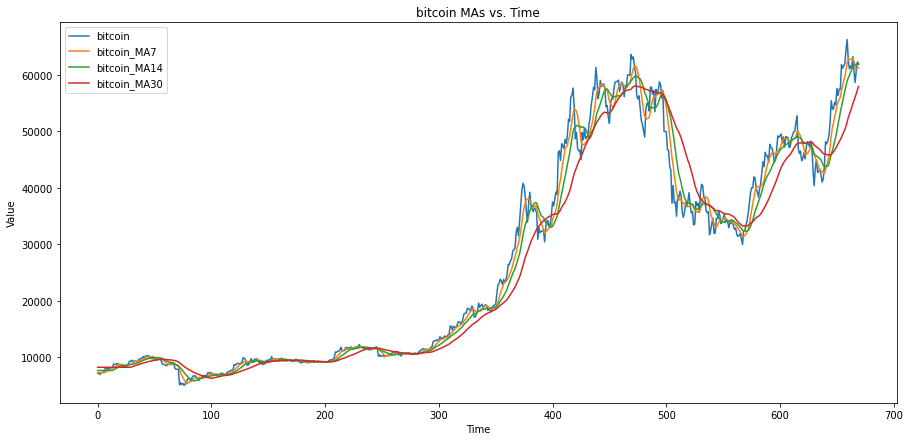

1.6042276429891875


In [27]:
cgp.take_mean(s_1)
df_feats = cgp.series_to_df_feats(s_1, LOOKBACKS, plot=True)

print(Statistics.sharpe_ratio(df_feats[f'{s_1.name}_DR']))


# Explore Exchanges on CoinGecko

In [28]:
exchanges = cgp.cg.get_exchanges_list()
print("There are", len(exchanges), "exchanges.")

by_24hr_vol = sorted(exchanges, key=lambda d: d['trade_volume_24h_btc'], reverse=True) 
print("Top 3 by 24 trading volume:", [exchange['id'] for exchange in by_24hr_vol[:3]])
by_trust_score = sorted(exchanges, key=lambda d: d['trust_score_rank'])
print("Top 3 by trust score:", [exchange['id'] for exchange in by_trust_score[:3]])

There are 100 exchanges.
Top 3 by 24 trading volume: ['binance', 'gdax', 'okex']
Top 3 by trust score: ['binance', 'gdax', 'huobi']


For now just use the highest 100 market cap coins on coingecko

In [29]:
COLS = ['id', 'current_price', 'high_24h', 'low_24h', 'market_cap', 'total_volume']

coin_market = cgp.cg.get_coins_markets(vs_currency=NAT_CURR)
df_market = pd.DataFrame(coin_market, columns=COLS)
df_market.set_index('id', inplace=True)

In [30]:
df_market

,current_price,high_24h,low_24h,market_cap,total_volume
id,,,,,
bitcoin,62596.000000,63546.00000,61587.000000,1178960595797,35891090925
ethereum,4565.180000,4674.90000,4465.870000,538950523887,21781666615
binancecoin,559.160000,571.02000,538.190000,93843986556,1912188268
tether,1.000000,1.02000,0.990444,72282965760,82461067206
solana,239.240000,245.69000,222.840000,72062521104,5373697334
...,...,...,...,...,...
decred,110.620000,114.82000,109.610000,1488484489,10202237
icon,2.200000,2.35000,2.190000,1477353594,99169307
kucoin-shares,19.060000,19.54000,18.400000,1466165583,33616595


From binomial theorem there are $2^{100}$ baskets so we need to find a way of filtering.

<b>There are also too many coins to pull all of them at once! We might have to create and host a database that contains updated data. We can pull around 50 or so coins at once.</b>

### Strategy
Take Pearson (Spearman?) correlation of dataframe to filter out some coins.

Idea:
We could train a model to take price data and try to spit out which coins are the most likely to be cointegrated. I think this could be some kind of 

In [31]:
# Create portfolio dataframe
port_val = cgp.create_portfolio(df_market[:50].index, start_date, end_date)
data = cgp.data
# Write to CSV

In [32]:
corr = data.corr()
valid = []


In [33]:
# FOR GRAPHMASTER: What if we do what you said about constructing a graph with coins as 
# nodes and edges are pairwise correlation to find which coins are most important to
# test first? Could we use a GNN?

corr

,bitcoin,ethereum,binancecoin,tether,solana,cardano,ripple,polkadot,dogecoin,usd-coin,...,tezos,the-graph,monero,eos,thorchain,pancakeswap-token,klay-token,flow,aave,kusama
bitcoin,1.000000,0.899123,0.878207,0.265496,0.629661,0.847127,0.819568,0.963216,0.698792,0.233591,...,0.787579,0.881568,0.914227,0.682623,0.848916,0.842050,0.862650,0.845653,0.920606,0.913100
ethereum,0.899123,1.000000,0.946117,0.238686,0.813655,0.963128,0.905904,0.888398,0.881139,0.239856,...,0.807413,0.678033,0.915737,0.730628,0.906301,0.910541,0.720760,0.708518,0.879152,0.908081
binancecoin,0.878207,0.946117,1.000000,0.219670,0.712054,0.921874,0.949915,0.894185,0.906667,0.240536,...,0.805964,0.736031,0.951978,0.816919,0.960713,0.985140,0.807686,0.815168,0.870759,0.936327
tether,0.265496,0.238686,0.219670,1.000000,0.200576,0.239962,0.143786,0.232864,0.162212,0.235712,...,0.167672,0.209068,0.212250,0.059380,0.161565,0.196245,0.186535,0.187494,0.204690,0.213095
solana,0.629661,0.813655,0.712054,0.200576,1.000000,0.830565,0.692815,0.667566,0.621866,0.222027,...,0.767081,0.339892,0.597963,0.414516,0.622278,0.657673,0.426753,0.414060,0.525312,0.657683
cardano,0.847127,0.963128,0.921874,0.239962,0.830565,1.000000,0.874346,0.851186,0.844869,0.267065,...,0.780408,0.648215,0.859583,0.675500,0.856196,0.887366,0.700144,0.711144,0.840201,0.892407
ripple,0.819568,0.905904,0.949915,0.143786,0.692815,0.874346,1.000000,0.831995,0.888178,0.175942,...,0.803314,0.659848,0.930199,0.840046,0.943554,0.938491,0.744133,0.738873,0.818145,0.885943
polkadot,0.963216,0.888398,0.894185,0.232864,0.667566,0.851186,0.831995,1.000000,0.712185,0.245987,...,0.850222,0.894641,0.894138,0.737770,0.882230,0.865578,0.875080,0.864139,0.917107,0.941046
dogecoin,0.698792,0.881139,0.906667,0.162212,0.621866,0.844869,0.888178,0.712185,1.000000,0.196327,...,0.647174,0.526770,0.869423,0.810022,0.915491,0.905842,0.601557,0.590764,0.773437,0.821049
usd-coin,0.233591,0.239856,0.240536,0.235712,0.222027,0.267065,0.175942,0.245987,0.196327,1.000000,...,0.166768,0.196614,0.213369,0.139039,0.189335,0.216195,0.179472,0.168707,0.196453,0.242892


In [ ]:
plt.histogram()

In [34]:

print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

print([coin.name_ for coin in coins], " are stationary \n")



Verifying coin price stationarity...
tether is not I(1)
usd-coin is not I(1)
binance-usd is not I(1)
dai is not I(1)
['bitcoin', 'ethereum', 'binancecoin', 'solana', 'cardano', 'ripple', 'polkadot', 'dogecoin', 'shiba-inu', 'terra-luna', 'avalanche-2', 'chainlink', 'wrapped-bitcoin', 'uniswap', 'litecoin', 'matic-network', 'algorand', 'bitcoin-cash', 'cosmos', 'stellar', 'axie-infinity', 'vechain', 'internet-computer', 'filecoin', 'tron', 'ftx-token', 'compound-ether', 'theta-token', 'ethereum-classic', 'fantom', 'crypto-com-chain', 'staked-ether', 'elrond-erd-2', 'near', 'okb', 'hedera-hashgraph', 'tezos', 'the-graph', 'monero', 'eos', 'thorchain', 'pancakeswap-token', 'klay-token', 'flow', 'aave', 'kusama']  are stationary 



In [45]:
coinNames = [coin.name_ for coin in coins]

df = data[coinNames].corr()

corrList = df.values.flatten()

(array([  2.,   2.,   8.,   6.,   6.,   4.,  18.,  16.,   4.,   8.,   4.,
          2.,   6.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   4.,
          0.,   4.,   6.,   6.,  12.,  40.,  34.,  58.,  60.,  84., 114.,
        158., 162., 192., 300., 370., 298., 124.]),
 array([-0.9115469 , -0.86375823, -0.81596956, -0.76818089, -0.72039221,
        -0.67260354, -0.62481487, -0.5770262 , -0.52923752, -0.48144885,
        -0.43366018, -0.3858715 , -0.33808283, -0.29029416, -0.24250549,
        -0.19471681, -0.14692814, -0.09913947, -0.0513508 , -0.00356212,
         0.04422655,  0.09201522,  0.13980389,  0.18759257,  0.23538124,
         0.28316991,  0.33095858,  0.37874726,  0.42653593,  0.4743246 ,
         0.52211327,  0.56990195,  0.61769062,  0.66547929,  0.71326796,
         0.76105664,  0.80884531,  0.85663398,  0.90442265,  0.95221133,
         1.        ]),
 <BarContainer object of 40 artists>)

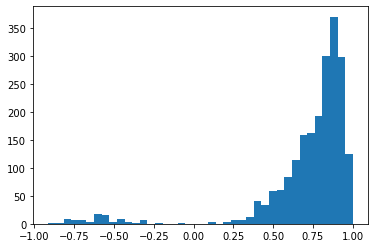

In [48]:
plt.hist(corrList,bins=40)

In [49]:
df.values[[np.arange(df.shape[0])]*2] = 0

/tmp/ipykernel_59902/4117618189.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[[np.arange(df.shape[0])]*2] = 0


In [50]:
df

,bitcoin,ethereum,binancecoin,solana,cardano,ripple,polkadot,dogecoin,shiba-inu,terra-luna,...,tezos,the-graph,monero,eos,thorchain,pancakeswap-token,klay-token,flow,aave,kusama
bitcoin,0.000000,0.899123,0.878207,0.629661,0.847127,0.819568,0.963216,0.698792,0.496048,0.770729,...,0.787579,0.881568,0.914227,0.682623,0.848916,0.842050,0.862650,0.845653,0.920606,0.913100
ethereum,0.899123,0.000000,0.946117,0.813655,0.963128,0.905904,0.888398,0.881139,0.677190,0.866497,...,0.807413,0.678033,0.915737,0.730628,0.906301,0.910541,0.720760,0.708518,0.879152,0.908081
binancecoin,0.878207,0.946117,0.000000,0.712054,0.921874,0.949915,0.894185,0.906667,0.581976,0.805528,...,0.805964,0.736031,0.951978,0.816919,0.960713,0.985140,0.807686,0.815168,0.870759,0.936327
solana,0.629661,0.813655,0.712054,0.000000,0.830565,0.692815,0.667566,0.621866,0.741265,0.939327,...,0.767081,0.339892,0.597963,0.414516,0.622278,0.657673,0.426753,0.414060,0.525312,0.657683
cardano,0.847127,0.963128,0.921874,0.830565,0.000000,0.874346,0.851186,0.844869,0.601080,0.888838,...,0.780408,0.648215,0.859583,0.675500,0.856196,0.887366,0.700144,0.711144,0.840201,0.892407
ripple,0.819568,0.905904,0.949915,0.692815,0.874346,0.000000,0.831995,0.888178,0.538346,0.767422,...,0.803314,0.659848,0.930199,0.840046,0.943554,0.938491,0.744133,0.738873,0.818145,0.885943
polkadot,0.963216,0.888398,0.894185,0.667566,0.851186,0.831995,0.000000,0.712185,0.522684,0.799457,...,0.850222,0.894641,0.894138,0.737770,0.882230,0.865578,0.875080,0.864139,0.917107,0.941046
dogecoin,0.698792,0.881139,0.906667,0.621866,0.844869,0.888178,0.712185,0.000000,0.572076,0.648892,...,0.647174,0.526770,0.869423,0.810022,0.915491,0.905842,0.601557,0.590764,0.773437,0.821049
shiba-inu,0.496048,0.677190,0.581976,0.741265,0.601080,0.538346,0.522684,0.572076,0.000000,0.676613,...,0.549621,0.228859,0.483245,0.395176,0.549368,0.504157,0.314835,0.220603,0.406936,0.503936
terra-luna,0.770729,0.866497,0.805528,0.939327,0.888838,0.767422,0.799457,0.648892,0.676613,0.000000,...,0.848772,0.534370,0.711713,0.519820,0.713808,0.762123,0.640050,0.633259,0.664811,0.776562


(array([  2.,   2.,   4.,   4.,   4.,  14.,   8.,   8.,  10.,  12.,  10.,
          4.,   0.,   4.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   4.,   4.,   4.,  10.,  26.,  46.,  60., 156., 184., 524.,
        850., 110.,   2.,   0.,   0.,   0.,  46.]),
 array([-0.77575662, -0.7313627 , -0.68696879, -0.64257487, -0.59818096,
        -0.55378704, -0.50939312, -0.46499921, -0.42060529, -0.37621138,
        -0.33181746, -0.28742355, -0.24302963, -0.19863572, -0.1542418 ,
        -0.10984789, -0.06545397, -0.02106005,  0.02333386,  0.06772778,
         0.11212169,  0.15651561,  0.20090952,  0.24530344,  0.28969735,
         0.33409127,  0.37848518,  0.4228791 ,  0.46727301,  0.51166693,
         0.55606085,  0.60045476,  0.64484868,  0.68924259,  0.73363651,
         0.77803042,  0.82242434,  0.86681825,  0.91121217,  0.95560608,
         1.        ]),
 <BarContainer object of 40 artists>)

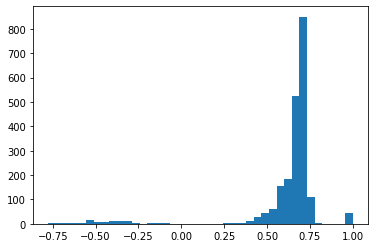

In [51]:
plt.hist(df.corr().values.flatten(),bins=40)

In [56]:
for _,row in df.iterrows:
    for coin in df.keys():
        row[coin] = 


/home/dave/anaconda3/envs/finml/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttributeError: 'numpy.ndarray' object has no attribute 'sigmoid'